In [2]:
pip install vnstock

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
import numpy as np
import datetime
import vnstock as vns
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score

In [4]:
df = vns.stock_historical_data(symbol='HPG',
                                start_date="2011-01-01",
                                end_date='2024-12-31', resolution='1D', type='stock')
df.set_index('time', inplace = True)

In [5]:
df.tail()

,open,high,low,close,volume,ticker
time,,,,,,
2024-07-23,28050,28200,27800,27800,15056900,HPG
2024-07-24,27750,27950,27100,27700,19233100,HPG
2024-07-25,27600,27650,27300,27350,13319700,HPG
2024-07-26,27350,27650,27350,27450,8806900,HPG
2024-07-29,27650,28100,27600,27900,15443700,HPG


In [6]:
df.head()

,open,high,low,close,volume,ticker
time,,,,,,
2012-03-26,1200,1200,1180,1180,412710,HPG
2012-03-27,1170,1190,1170,1170,964010,HPG
2012-03-28,1160,1170,1160,1170,282250,HPG
2012-03-29,1160,1180,1160,1170,438730,HPG
2012-03-30,1180,1200,1170,1180,685020,HPG


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3082 entries, 2012-03-26 to 2024-07-29
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   open    3082 non-null   int64 
 1   high    3082 non-null   int64 
 2   low     3082 non-null   int64 
 3   close   3082 non-null   int64 
 4   volume  3082 non-null   int64 
 5   ticker  3082 non-null   object
dtypes: int64(5), object(1)
memory usage: 168.5+ KB


In [8]:
df.describe()

,open,high,low,close,volume
count,3082.000000,3082.000000,3082.000000,3082.000000,3.082000e+03
mean,12070.161259,12233.163855,11911.326736,12065.730694,9.794728e+06
std,9982.992577,10110.272589,9847.707640,9966.455325,1.199227e+07
min,970.000000,1010.000000,970.000000,990.000000,6.000000e+03
25%,3780.000000,3830.000000,3740.000000,3780.000000,1.008590e+06
50%,9250.000000,9380.000000,9170.000000,9250.000000,4.456775e+06
75%,19317.500000,19580.000000,19050.000000,19350.000000,1.565688e+07
max,39910.000000,40180.000000,39560.000000,39910.000000,9.965880e+07


In [9]:
df_train = df[:datetime.date(2020,2,28)]['close']
df_test = df[datetime.date(2020,3,1):]['close']

In [10]:
len(df_train)

1977

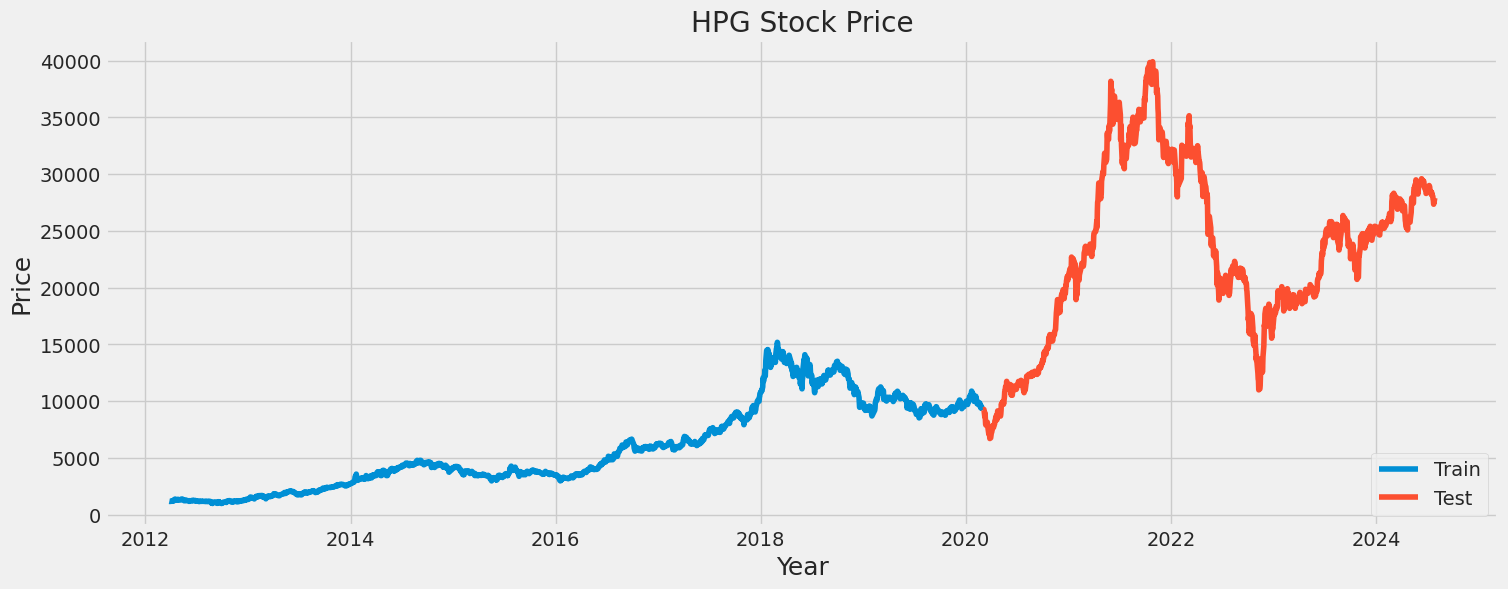

In [11]:
plt.figure(figsize=(16,6))
plt.title('HPG Stock Price')
plt.xlabel('Year', fontsize=18)
plt.ylabel('Price', fontsize=18)
plt.plot(df_train)
plt.plot(df_test)
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

In [12]:
data = df['close']
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * 0.66 ))


In [13]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset.reshape(-1,1))

scaled_data

array([[0.00488181],
       [0.00462487],
       [0.00462487],
       ...,
       [0.67728674],
       [0.67985612],
       [0.69141829]])

In [14]:
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(50, len(train_data)):
    x_train.append(train_data[i-50:i, 0])
    y_train.append(train_data[i, 0])
print(len(train_data[0]))
# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape
y_train.shape

1


(1985,)

In [15]:
# Xây dựng mô hình LSTM
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 128)           66560     
                                                                 
 dropout (Dropout)           (None, 50, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 25)                1625      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 117619 (459.45 KB)
Trainable params: 11761

In [16]:
model.fit(x_train, y_train, batch_size=1, epochs=25)

Epoch 1/25
1985/1985 [==============================] - 102s 44ms/step - loss: 4.8049e-04
Epoch 2/25
1985/1985 [==============================] - 79s 40ms/step - loss: 3.2843e-04
Epoch 3/25
1985/1985 [==============================] - 78s 39ms/step - loss: 2.9311e-04
Epoch 4/25
1985/1985 [==============================] - 78s 39ms/step - loss: 2.7409e-04
Epoch 5/25
1985/1985 [==============================] - 80s 40ms/step - loss: 2.3443e-04
Epoch 6/25
1985/1985 [==============================] - 79s 40ms/step - loss: 2.2447e-04
Epoch 7/25
1985/1985 [==============================] - 79s 40ms/step - loss: 1.7820e-04
Epoch 8/25
1985/1985 [==============================] - 78s 39ms/step - loss: 2.1248e-04
Epoch 9/25
1985/1985 [==============================] - 76s 38ms/step - loss: 1.8572e-04
Epoch 10/25
1985/1985 [==============================] - 76s 38ms/step - loss: 1.6972e-04
Epoch 11/25
1985/1985 [==============================] - 77s 39ms/step - loss: 1.4809e-04
Epoch 12/25
1985/1

In [17]:
test_data = scaled_data[training_data_len - 50: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:]
for i in range(50, len(test_data)):
    x_test.append(test_data[i-50:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print('Test data RMSE:', rmse)
print('Test data R2 score:', r2_score(y_test, predictions))
print('Test data MAE:', mean_absolute_error(y_test, predictions))
print('Test data MSE:', mean_squared_error(y_test, predictions))
print('Test data EVS:', explained_variance_score(y_test, predictions))
mape = np.mean(np.abs(y_test - predictions) / np.abs(y_test))
print('Test data MAPE:', mape)


33/33 [==============================] - 2s 25ms/step
Test data RMSE: 9130.93984521797
Test data R2 score: 0.8412295856262405
Test data MAE: 2115.300052792204
Test data MSE: 8037433.599127556
Test data EVS: 0.9255294400340162
Test data MAPE: 0.3340714686509385


In [18]:
train_loss = model.evaluate(x_train, y_train)
test_loss = model.evaluate(x_test, y_test)

print(f'Train Loss: {train_loss}')
print(f'Test Loss: {test_loss}')

33/33 [==============================] - 2s 25ms/step - loss: 625730304.0000
Train Loss: 2.0630674043786712e-05
Test Loss: 625730304.0


<ipython-input-19-5314a7927e81>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


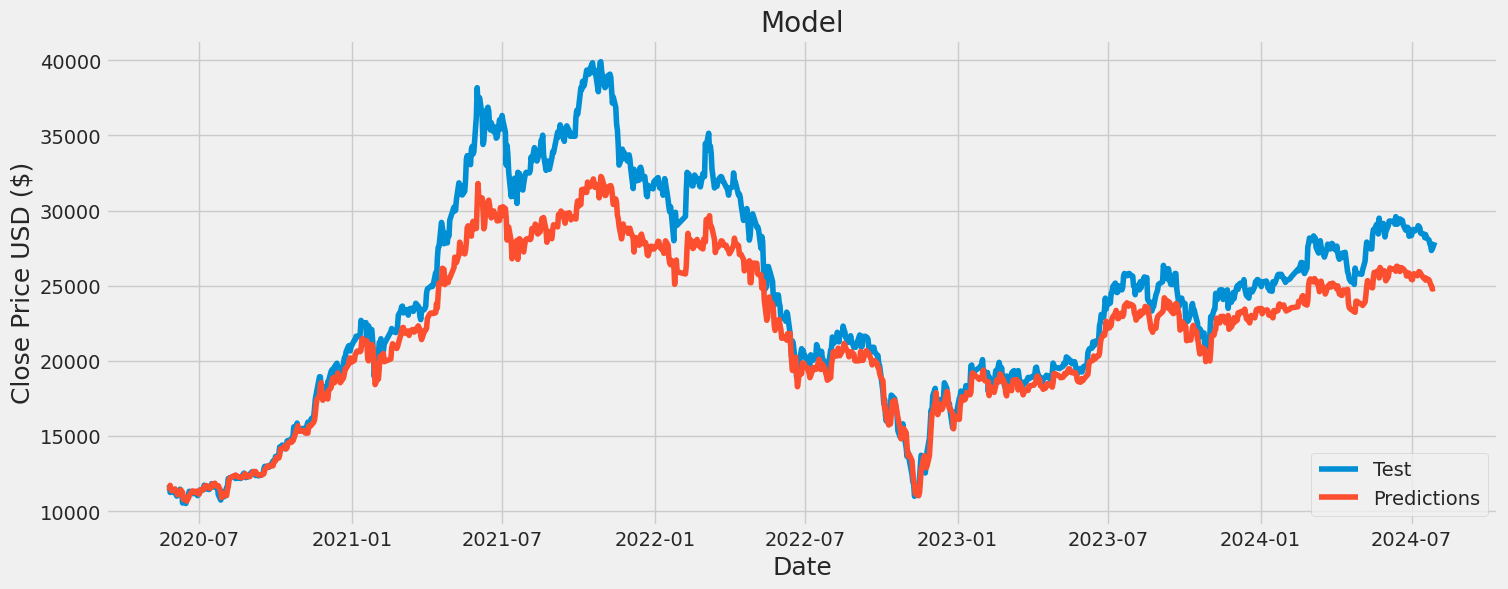

In [19]:
train = df[:training_data_len]
valid = df[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
#plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])
plt.legend(['Test', 'Predictions'], loc='lower right')
plt.show()

In [20]:
# Show the valid and predicted prices
valid[['close', 'Predictions']]

,close,Predictions
time,,
2020-05-26,11750,11395.961914
2020-05-27,11260,11724.595703
2020-05-28,11260,11501.300781
2020-05-29,11350,11368.940430
2020-06-01,11450,11400.764648
...,...,...
2024-07-23,27800,25257.443359
2024-07-24,27700,25081.335938
2024-07-25,27350,25010.269531
